In [1]:
import ROOT

# Open the ROOT file and access the TTree
file = ROOT.TFile.Open("tnptuples/data_EGamma_Run2022D.root")
tree = file.Get("tnpEleTrig/fitter_tree")

# Define the observable
x = ROOT.RooRealVar("x", "pair_mass", 50, 130)

# Create a histogram from TTree data and convert it to RooDataHist
hist_name = "hist_pair_mass"
num_bins = 50
hist = ROOT.TH1F(hist_name, "Histogram of pair_mass", num_bins, 50, 130)
tree.Draw("pair_mass>>" + hist_name, "passingMVA122Xwp90isoV1 == 0")
rooHist = ROOT.RooDataHist("rooHist", "Histogram", ROOT.RooArgList(x), hist)

# CrystalBall Signal Parameters
mu_cb = ROOT.RooRealVar("mu_cb", "mean of CB", 90, 85, 95)
# sigmaL = ROOT.RooRealVar("sigmaL", "left width", 2, 0.1, 20)
# sigmaR = ROOT.RooRealVar("sigmaR", "right width", 2, 0.1, 20)
sigmaLR = ROOT.RooRealVar("sigmaLR", "right width", 5, 0.1, 10)
alphaL = ROOT.RooRealVar("alphaL", "left alpha", 1, 0.1, 20)
nL = ROOT.RooRealVar("nL", "left n", 5, 0.1, 20)
alphaR = ROOT.RooRealVar("alphaR", "right alpha", 1, 0.1, 20)
nR = ROOT.RooRealVar("nR", "right n", 5, 0.1, 20)
crystalBall = ROOT.RooCrystalBall("crystalBall", "CrystalBall", x, mu_cb, sigmaLR, alphaL, nL, alphaR, nR)

# Exponential Background Parameters
lambda_exp = ROOT.RooRealVar("lambda_exp", "slope of exp", -0.01, -5.0, 0.0)
exp_bg = ROOT.RooExponential("exp_bg", "Exponential Background", x, lambda_exp)

# Calculate the total number of events in the histogram
total_events = hist.Integral()

# Calculate initial values for nsig and nbkg based on fractions of total events
nsig_initial = total_events * 0.3
nbkg_initial = total_events * 0.7

# Define nsig and nbkg with these initial values
nsig = ROOT.RooRealVar("nsig", "number of signal events", nsig_initial, 0, total_events)
nbkg = ROOT.RooRealVar("nbkg", "number of background events", nbkg_initial, 0, total_events)


# Composite Model
model = ROOT.RooAddPdf("model", "Signal + Background", ROOT.RooArgList(crystalBall, exp_bg), ROOT.RooArgList(nsig, nbkg))

# Fit the Composite Model to the Histogram Data
result = model.fitTo(rooHist, ROOT.RooFit.Save())

# Plotting the Fit Result and Components
c = ROOT.TCanvas("c", "Fit Result", 800, 600)
frame = x.frame(ROOT.RooFit.Title("Fit with Double-sided Crystal Ball and Exponential Background"))
rooHist.plotOn(frame, ROOT.RooFit.DataError(ROOT.RooAbsData.Poisson)) 
model.plotOn(frame)

model.plotOn(frame, ROOT.RooFit.Components(crystalBall), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kRed))
model.plotOn(frame, ROOT.RooFit.Components(exp_bg), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlue))
frame.Draw()

Welcome to JupyROOT 6.30/04


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -6016863.481 Edm =       88478.44583 NCalls =     49
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -6020014.179
  Edm           : 115545.4419
  Internal parameters:	[     -1.142194548     -1.142194548      1.481323767                0     -1.177521524     -0.532324639     0.4115168461    -0.4115168461   -0.01010118188]	
  Internal gradient  :	[      -13719.4608     -83406.21241      559515.2921      1577.032536      664.1488349     -6405.029632      13308.49822     -31055.70461      29320.73302]	
  Internal covariance matrix:
[[  4.8686949e-06              0              0              0              0              0        

[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (crystalBall,exp_bg)
Minuit2Minimizer: Minimize with max-calls 4500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Invalid Minimum - status = 3
FVAL  = -6.04717e+06
Edm   = 0.240027
Nfcn  = 681
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (crystalBall)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (exp_bg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


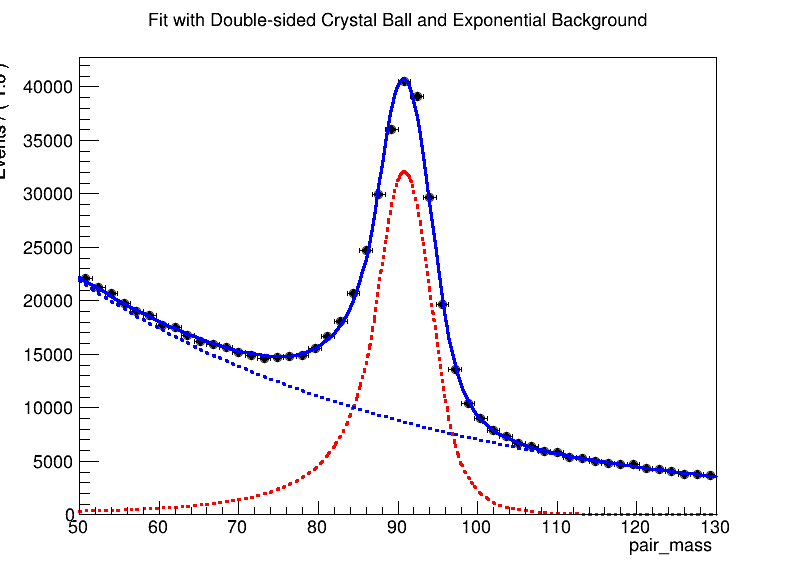

In [2]:
c.Draw()

In [3]:
fit_params = result.floatParsFinal()  # Assuming 'result' is the fit result from model.fitTo(...)

print(f"{'name':<10} {'value (rounded)':<20} {'at limit':<10}")
print("-" * 40)

for i in range(fit_params.getSize()):
    param = fit_params.at(i)
    name = param.GetName()
    value = param.getVal()
    at_limit = False
    print(f"{name:<10} {value:<20.6f} {str(at_limit):<10}")

name       value (rounded)      at limit  
----------------------------------------
alphaL     0.952565             False     
alphaR     1.515874             False     
lambda_exp -0.022724            False     
mu_cb      90.778947            False     
nL         2.553480             False     
nR         7.088831             False     
nbkg       504222.273501        False     
nsig       223465.738162        False     
sigmaLR    3.519760             False     
